## <font color = '#6495ED'>  ________________ **Reinforcement Learning - Lunar Lander** _________________
#### _______________________________________________Academic Year: 2024/2025 _____________________________________________

<div style="text-align: center;">
    <strong>Group Members</strong>
    <table style="margin: 0 auto; border-collapse: collapse; border: 1px solid black;">
        <tr>
            <th style="border: 1px solid white; padding: 8px;">Name</th>
            <th style="border: 1px solid white; padding: 8px;">Student ID</th>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Afonso Ascenção</td>
            <td style="border: 1px solid white; padding: 8px;">20240684</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Afonso Silva</td>
            <td style="border: 1px solid white; padding: 8px;">20240495</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Elcano Gaspar</td>
            <td style="border: 1px solid white; padding: 8px;">20241021</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Osmáiny Leontina</td>
            <td style="border: 1px solid white; padding: 8px;">20191506</td>
        </tr>
    </table>
</div>

### <font color = '#6495ED'>**Project Description**</font>

#### *Objective:*
The goal of this project is to develop and evaluate two Reinforcement Learning (RL) agents capable of solving two distinct environments from the Gymnasium library. The project aims to explore the design and implementation of RL algorithms in environments with diverse state and action spaces.

#### *Environments:*
We choose two different environments from the Gymnasium library that were not covered in class. At least one environment must have a non-discrete/non-tabular observation space (e.g., continuous or mixed).

#### *Methodology:*
The project follow these steps:

- Environment Selection: Choose two distinct Gymnasium environments, with at least one having a non-discrete observation space.
- Algorithm Implementation: Implement two different RL algorithms (SARSA and PPO) for each chosen environment.
- Agent Training: Train the developed RL agents in their respective environments.
- Evaluation and Analysis: Record and analyze performance metrics such as total reward per episode/return, convergence speed, and the balance between exploration and exploitation.
- Visualization: Provide visualizations of learning progress, including reward curves and success rates.
- Comparative Analysis: Perform a comparative analysis of the chosen algorithms and environments.
- Behavior Interpretation: Interpret and explain the agent's behavior in each environment, analyzing its actions and learning patterns.

#### *Success Metrics:*
Our primary success metrics will include:

Total Reward per Episode/Return: To measure the overall performance of the agent.
Convergence Speed: To evaluate how quickly the agent learns an effective policy.
Exploration vs. Exploitation Balance: To understand the agent's strategy for discovering and leveraging rewards.
Visualizations: Clarity and interpretability of plots representing learning and performance.

Argumentation of Methods: The usage and argumentation of different learning methods, their relevance, and usefulness in solving the problem will be the focus of the evaluation.

#### *Variable description:*
| **ATTRIBUTE**               | **DESCRIPTION**                                                                                   |
|-----------------------------|---------------------------------------------------------------------------------------------------|
| State               | The current observation of the environment, used by the agent to make decisions.                                 |
| Action               | The decision made by the agent at a given state, which affects the environment.                                       |
| label               | A scalar feedback signal from the environment indicating the immediate success or failure of an action, used to guide agent learning        |

### <font color = '#6495ED'>  **1. Libraries, Environment, Configuration** </font>

#### <font color = '#6495ED'> **1.1. Libraries import or install** </font>

In [1]:
'''
# For GPU support, install the following packages:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip install gymnasium[box2d]
'''

'\n# For GPU support, install the following packages:\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128\n!pip install gymnasium[box2d]\n'

In [6]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import gymnasium as gym
import itertools
import time
import matplotlib.pyplot as plt
import os
import cv2

> Testing GPU availability:

In [7]:
# check if GPU is available
torch.cuda.is_available()

True

#### <font color = '#6495ED'> **1.2. Environment - Lunar Lander Continuous-V3** </font>

This environment is part of the Box2D environments. This continuous control task requires a lander to touch down softly at the center of a landing pad using two engine thrusters.

- **State space**: 8D vector [position, velocity, angle, angular velocity, left/right leg contact]
- **Action space**: 2D continuous vector (main engine, side engine)
- **Goal**: Land without crashing
- **Reward**: Based on proximity to landing zone, velocity, angle, leg contact, and fuel use

In [8]:
env = gym.make("LunarLanderContinuous-v3")

print("State shape:", env.observation_space.shape)
state_size = env.observation_space.shape[0]
print("State size:", state_size)
print("Number of continuous actions:", env.action_space.shape[0])

State shape: (8,)
State size: 8
Number of continuous actions: 2


#### <font color = '#6495ED'> **1.3. Action Space Discretization** </font>

In [9]:
main_bins = [-1, 1]
lateral_bins = [-1, 0, 1]

discrete_actions = np.array(list(itertools.product(main_bins, lateral_bins)))
number_actions = len(discrete_actions)

In [10]:
discrete_actions

array([[-1, -1],
       [-1,  0],
       [-1,  1],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1]])

### Build Deep Q-Network (DQN) for LunarLanderContinuous-v3

We will use a Deep Q-Network (DQN) to learn the optimal policy for the Lunar Lander environment. The DQN will approximate the Q-values for each action given a state, allowing the agent to select actions based on learned values.

    Observation:
        Type: Box(8) - continuous
        Num     Observation               Min                             Max
        0       Lander X Position         -1.5                            1.5
        1       Lander Y Position         -1.5                            1.5
        2       Lander X Velocity         -5.0                            5.0
        3       Lander Y Velocity         -5.0                            5.0
        4       Lander Angle              -3.14 rad (approx -180 deg)     3.14 rad (approx -180 deg)
        5       Lander Angular Velocity   -5.0                            5.0
        6       Left Leg Contact           0                              1
        7       Right Leg Contact          0                              1
    Actions:
        Type: Discrete (6)
        Num     Action                Main Engine (ME)              Side Engine (SE)
        0:      ME Off LE On             -1.0                             -1.0
        1:      ME Off SE Off            -1.0                               0
        2:      ME Off RE On             -1.0                               1
        3:      ME On LE On               1.0                             -1.0
        4:      ME On SE Off              1.0                               0
        5:      ME On RE On               1.0                               1

    Note: LE = Left Engine, RE = Right Engine

Discrete actions: For the Main Engine (ME), we have two options: on or off. For the Side Engine (SE), we can choose to turn the Left Engine (LE) on, turn the Right Engine (RE) on, or keep them both off. This results in a total of 6 discrete actions.

### <font color = '#6495ED'>  **2. Model** </font>

#### <font color = '#6495ED'>  **2.1 Model Configuration** </font>

> Hyper Parameters:

In [11]:
learning_rate = 5e-4
minibatch_size = 64
discount_factor = 0.99
replay_buffer_size = int(1e5)
interpolation_parameter = 1e-3

> NN architecture:

In [12]:
class Network(nn.Module):
  def __init__(self, state_size, action_size, seed=42):
      super(Network, self).__init__()
      self.seed = torch.manual_seed(seed)
      self.fc1 = nn.Linear(state_size, 128)
      self.fc2 = nn.Linear(128, 128)
      self.fc3 = nn.Linear(128, 64)
      self.fc4 = nn.Linear(64, action_size)

  def forward(self, state):
      x = F.relu(self.fc1(state))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      return self.fc4(x)  # Output Q-values for each discrete action

> Replay Memory:

In [13]:
class ReplayMemory(object):

  def __init__(self, capacity):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.capacity = capacity
    self.memory = []

  def push(self, event):
    self.memory.append(event)
    if len(self.memory) > self.capacity:
      del self.memory[0]

  def sample(self, batch_size):
    experiences = random.sample(self.memory, k = batch_size)
    states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
    actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
    rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
    next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
    dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
    return states, next_states, actions, rewards, dones

> Agent:

In [14]:
class Agent():

  def __init__(self, state_size, action_size):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.state_size = state_size
    self.action_size = action_size
    self.discrete_actions = discrete_actions
    self.local_qnetwork = Network(state_size, action_size).to(self.device)
    self.target_qnetwork = Network(state_size, action_size).to(self.device)
    self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
    self.memory = ReplayMemory(replay_buffer_size)
    self.t_step = 0

  def step(self, state, action_idx, reward, next_state, done):
    self.memory.push((state, action_idx, reward, next_state, done))
    self.t_step = (self.t_step + 1) % 4
    if self.t_step == 0:
      if len(self.memory.memory) > minibatch_size:
        experiences = self.memory.sample(minibatch_size)
        self.learn(experiences, discount_factor)

  def act(self, state, epsilon = 0.):
    state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    self.local_qnetwork.eval()
    with torch.no_grad():
      q_values = self.local_qnetwork(state).cpu().data.numpy().squeeze()
    self.local_qnetwork.train()

    if np.random.rand() < epsilon:
        action_idx = np.random.randint(self.action_size)
    else:
        action_idx = np.argmax(q_values)
    return action_idx  # Return index


  def learn(self, experiences, discount_factor):
    states, next_states, actions, rewards, dones = experiences
    # For continuous actions, use MSE between predicted and taken actions (DDPG/A2C would be better)
    actions = actions.long()
    q_expected = self.local_qnetwork(states).gather(1, actions)
    q_targets_next = self.target_qnetwork(next_states).max(1)[0].unsqueeze(1)
    q_targets = rewards + discount_factor * q_targets_next * (1 - dones)
    loss = F.mse_loss(q_expected, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)

  def soft_update(self, local_model, target_model, interpolation_parameter):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

In [15]:
agent = Agent(state_size, number_actions)

#### <font color = '#6495ED'>  **2.2 Model Training** </font>

##### <font color = '#6495ED'>  **2.2.1 Stage 1** </font>

In [46]:
number_episodes = 2000
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
epsilon_decay_value  = 0.996
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)

# Store all episode rewards (not just the last 100)
episode_rewards = []

# Starting timer
start_time = time.time()

for episode in range(1, number_episodes + 1):
  state, _ = env.reset()
  score = 0
  for t in range(maximum_number_timesteps_per_episode):
    action_idx = agent.act(state, epsilon)
    action = discrete_actions[action_idx]
    next_state, reward, done, _, _ = env.step(action)

    agent.step(state, action_idx, reward, next_state, done)
    state = next_state
    score += reward
    if done:
      break
  scores_on_100_episodes.append(score)
  episode_rewards.append(score)  # Store the reward for this episode
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
  print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)), end = "")
  if episode % 100 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(episode, np.mean(scores_on_100_episodes), epsilon))

  if np.mean(scores_on_100_episodes) >= 220.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
    torch.save(agent.local_qnetwork.state_dict(), 'DQN_stage_1.pth')
    break

# Ending timer and calculating elapsed time
elapsed_time = time.time() - start_time
print(f"\n Training complete in {elapsed_time:.2f} seconds")

Episode 100	Average Score: -315.93	Epsilon: 0.67
Episode 200	Average Score: -109.55	Epsilon: 0.45
Episode 300	Average Score: -5.15	Epsilon: 0.30
Episode 400	Average Score: 90.93	Epsilon: 0.20
Episode 500	Average Score: 159.89	Epsilon: 0.13
Episode 600	Average Score: 189.01	Epsilon: 0.09
Episode 694	Average Score: 220.27
Environment solved in 694 episodes!	Average Score: 220.27

 Training complete in 814.40 seconds


#### Evaluation

> Episode Reward Curve:

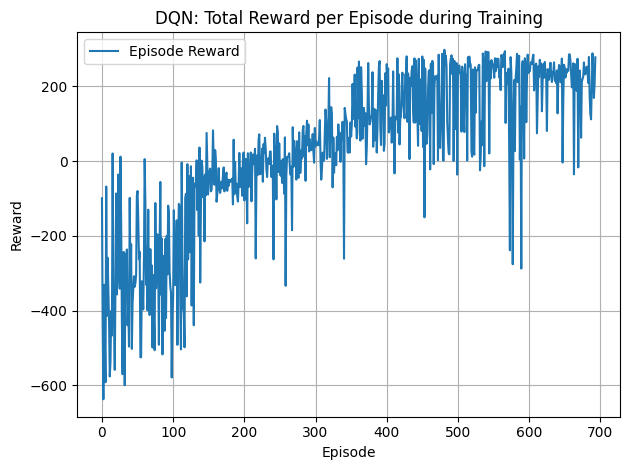

In [47]:
# Raw episode rewards
plt.plot(episode_rewards, label="Episode Reward")
plt.title("DQN: Total Reward per Episode during Training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

> Smoothed Reward Curve (Moving Average):

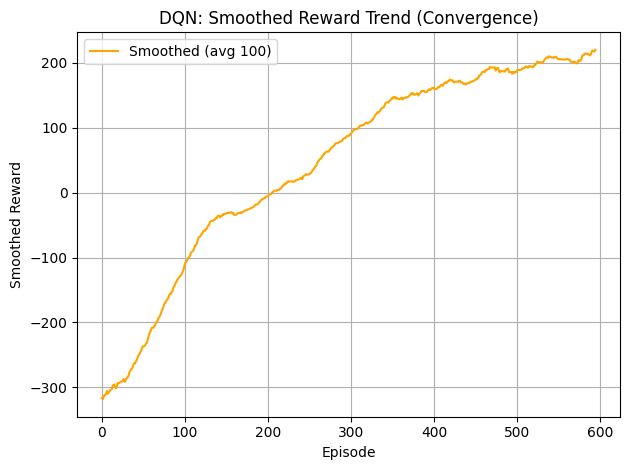

In [48]:
# Smoothed reward trend (moving average)
window = 100
if len(episode_rewards) >= window:
    smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.plot(smoothed, label=f"Smoothed (avg {window})", color="orange")
    plt.title("DQN: Smoothed Reward Trend (Convergence)")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

> Evaluation Table:

In [11]:
def evaluate_agent(agent, env_name, discrete_actions, num_episodes=100):
    env = gym.make(env_name, render_mode=None)
    crash_count = 0
    out_of_viewport_count = 0
    landing_pad_count = 0
    success_count = 0
    total_rewards = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        crashed = False
        out_of_viewport = False
        landed_on_pad = False
        success = False
        episode_reward = 0

        while not done:
            action_idx = agent.act(state, epsilon=0.0)
            action = discrete_actions[action_idx]
            state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            if truncated:
                break

        if abs(state[0]) > 1:
            out_of_viewport = True
        if hasattr(env.unwrapped, 'game_over') and env.unwrapped.game_over:
            crashed = True
        if not crashed and abs(state[0]) < 0.1:
            landed_on_pad = True

        if episode_reward >= 200:
            success = True

        crash_count += int(crashed)
        out_of_viewport_count += int(out_of_viewport)
        landing_pad_count += int(landed_on_pad and not crashed)
        success_count += int(success)
        total_rewards.append(episode_reward)

    env.close()
    print(f"Over {num_episodes} episodes:")
    print(f"\nSuccess rate: {success_count/num_episodes:.2%}")
    print(f"Crash rate: {crash_count/num_episodes:.2%}")
    print(f"Out of viewport rate: {out_of_viewport_count/num_episodes:.2%}")
    print(f"Landing on pad (no crash) rate: {landing_pad_count/num_episodes:.2%}")
    print(f"Average reward: {np.mean(total_rewards):.2f}")
    print(f"Average reward standard deviation: {np.std(total_rewards):.2f}")

In [12]:
agent.local_qnetwork.load_state_dict(torch.load('DQN_stage_1.pth', weights_only=True))
agent.target_qnetwork.load_state_dict(torch.load('DQN_stage_1.pth', weights_only=True))
evaluate_agent(agent, "LunarLanderContinuous-v3", discrete_actions, num_episodes=1000)

Over 1000 episodes:

Success rate: 69.90%
Crash rate: 1.00%
Out of viewport rate: 0.00%
Landing on pad (no crash) rate: 24.20%
Average reward: 220.39
Average reward standard deviation: 59.55


The agent has a crash rate of only 1% and successfully lands on the pad 24.2% of the time without crashing. The average reward per episode is approximately 220.39, indicating that the agent has learned to navigate the environment effectively.

##### <font color = '#6495ED'>  **2.2.2 Stage 2** </font>

In [13]:
# Load the trained model weights
agent.local_qnetwork.load_state_dict(torch.load('DQN_stage_1.pth', weights_only=True))
agent.target_qnetwork.load_state_dict(torch.load('DQN_stage_1.pth', weights_only=True))

# Store all episode rewards (not just the last 100)
episode_rewards = []

# Now continue training as before
number_episodes = 2000
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
epsilon_decay_value  = 0.996
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)

# Starting timer
start_time = time.time()

for episode in range(1, number_episodes + 1):
    state, _ = env.reset()
    score = 0
    for t in range(maximum_number_timesteps_per_episode):
        action_idx = agent.act(state, epsilon)
        action = discrete_actions[action_idx]
        next_state, reward, done, _, _ = env.step(action)


        distance_from_pad = abs(next_state[0])
        reward -= distance_from_pad * 2  # Penalize being far from the center

        reward -= 0.01  # Gentle time penalty


        agent.step(state, action_idx, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    scores_on_100_episodes.append(score)
    episode_rewards.append(score)  # Store the reward for this episode
    epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)), end = "")
    if episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(episode, np.mean(scores_on_100_episodes), epsilon))
    if np.mean(scores_on_100_episodes) >= 250.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
        torch.save(agent.local_qnetwork.state_dict(), 'DQN_stage_2.pth')
        break

# Ending timer and calculating elapsed time
elapsed_time = time.time() - start_time
print(f"\n Training complete in {elapsed_time:.2f} seconds")

Episode 100	Average Score: -230.59	Epsilon: 0.67
Episode 200	Average Score: -312.53	Epsilon: 0.45
Episode 300	Average Score: -269.75	Epsilon: 0.30
Episode 400	Average Score: -104.49	Epsilon: 0.20
Episode 500	Average Score: 81.48	Epsilon: 0.13
Episode 600	Average Score: 175.49	Epsilon: 0.09
Episode 700	Average Score: 214.49	Epsilon: 0.06
Episode 800	Average Score: 204.11	Epsilon: 0.04
Episode 900	Average Score: 224.14	Epsilon: 0.03
Episode 1000	Average Score: 224.24	Epsilon: 0.02
Episode 1100	Average Score: 228.44	Epsilon: 0.01
Episode 1200	Average Score: 221.14	Epsilon: 0.01
Episode 1300	Average Score: 213.18	Epsilon: 0.01
Episode 1400	Average Score: 232.65	Epsilon: 0.01
Episode 1500	Average Score: 245.23	Epsilon: 0.01
Episode 1600	Average Score: 245.42	Epsilon: 0.01
Episode 1625	Average Score: 250.11
Environment solved in 1625 episodes!	Average Score: 250.11

 Training complete in 1040.31 seconds


#### Evaluation

> Episodic Reward Curve:

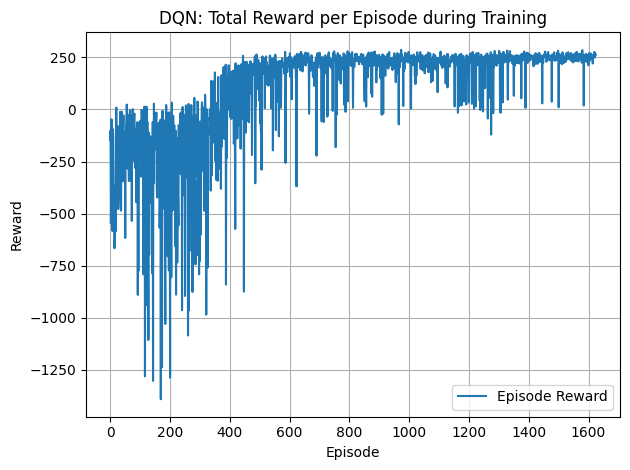

In [14]:
# Raw episode rewards
plt.plot(episode_rewards, label="Episode Reward")
plt.title("DQN: Total Reward per Episode during Training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

> Smoothed Reward Curve (Moving Average):

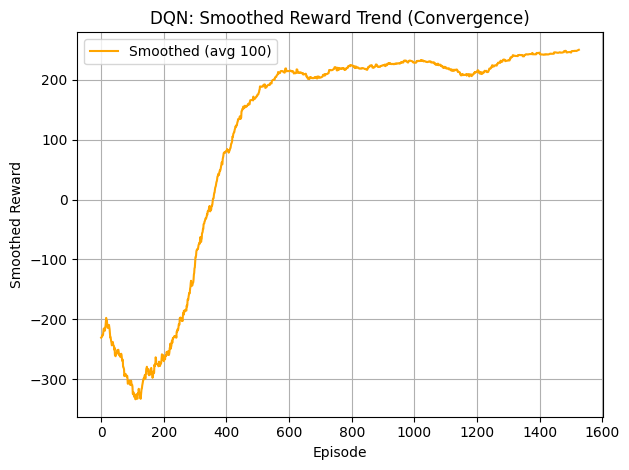

In [15]:
# Smoothed reward trend (moving average)
window = 100
if len(episode_rewards) >= window:
    smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.plot(smoothed, label=f"Smoothed (avg {window})", color="orange")
    plt.title("DQN: Smoothed Reward Trend (Convergence)")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

> Evaluation Table:

In [13]:
agent.local_qnetwork.load_state_dict(torch.load('DQN_stage_2.pth', weights_only=True))
agent.target_qnetwork.load_state_dict(torch.load('DQN_stage_2.pth', weights_only=True))
evaluate_agent(agent, "LunarLanderContinuous-v3", discrete_actions, num_episodes=1000)

Over 1000 episodes:

Success rate: 100.00%
Crash rate: 0.00%
Out of viewport rate: 0.00%
Landing on pad (no crash) rate: 98.80%
Average reward: 282.83
Average reward standard deviation: 19.58


### <font color = '#6495ED'>  **3. Agent Video and Interactive Visualization** </font>

In [16]:
def play_with_pygame(agent, env_name, discrete_actions, delay=0.03):
    env = gym.make(env_name, render_mode="human", gravity=-10.0,
               enable_wind=True, wind_power=15.0, turbulence_power=1.5)
    state, _ = env.reset()
    done = False
    while not done:
        action_idx = agent.act(state, epsilon=0.0)  # Greedy action
        action = discrete_actions[action_idx]
        state, reward, done, truncated, info = env.step(action)
        env.render()
        time.sleep(delay)
        if truncated:
            break
    env.close()

Loading the agent weights and playing the game:

In [18]:
# Instantiate agent
agent = Agent(state_size, number_actions)

# Load the trained weights
agent.local_qnetwork.load_state_dict(torch.load('DQN_stage_2.pth', weights_only=True))
agent.target_qnetwork.load_state_dict(torch.load('DQN_stage_2.pth', weights_only=True))

<All keys matched successfully>

In [19]:
# Play using the trained agent
play_with_pygame(agent, "LunarLanderContinuous-v3", discrete_actions, delay=0.03)

Video Recording:

In [20]:
video_folder = './dqn_lander_video'
os.makedirs(video_folder, exist_ok=True)
video_path = os.path.join(video_folder, 'all_episodes_cv2.mp4')

env = gym.make("LunarLanderContinuous-v3", render_mode="rgb_array")
frames = []

num_episodes = 10
fps = 30

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    while not done:
        frame = env.render()
        frames.append(frame)
        action_idx = agent.act(state, epsilon=0.0)
        action = discrete_actions[action_idx]
        state, reward, done, truncated, info = env.step(action)
        if truncated:
            break

env.close()

# Get frame size
height, width, layers = frames[0].shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

for frame in frames:
    # Convert RGB (gym) to BGR (cv2)
    out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

out.release()
print(f"Video saved to {video_path}")

Video saved to ./dqn_lander_video\all_episodes_cv2.mp4
